<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import copy



import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!

import random


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import time

tic = time.time()  # Start the timer
initial_run = 0


### Set Random Seeds

In [2]:
##  Random Seed
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
## ------------------

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  Once I learned that it was a little less complicated to figure out how to slice and dice the image-datasets into mini-datasets with equal number of classes.

The second biggest after making a model and training it with the train and val datasets, was using the model to make predictions on the test set.  Unlike the train and validation sets I created, the test-set wouldn't be read by model.evaluate or model.predict.   Although this problem is at the very bottom of the jupyter notebook I tried to fix it here at the top.   About 100 stackoverflow examples later I think I got one [here](https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset)


Another problem that reoccurs is anytime I inadvertently want to mess with batch-size on the x_test dataset, I change the shapen from (None, 32, 32, 3) to (None, None, 32, 32, 3) and then it doesn't fit in model.evaluate() anymore.   I created a backup copy of x_test so I don't have to rerun the entire notebook each time.

In [3]:
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


# believe I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

y_test = get_labels_from_tfdataset(x_test)



 # with_info = True, 
#If anything goes wrong, its because I added "as_supervised=True" to this above

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


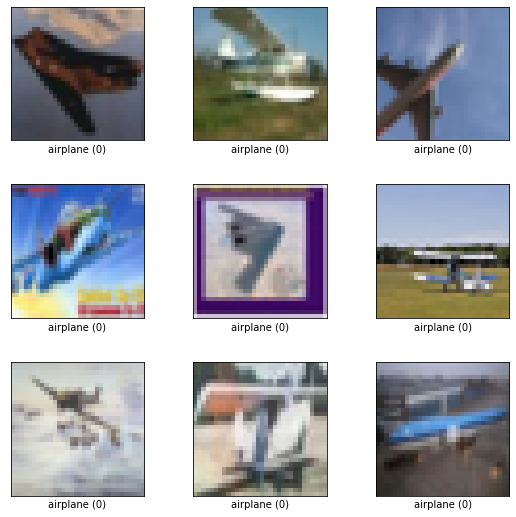

In [4]:
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

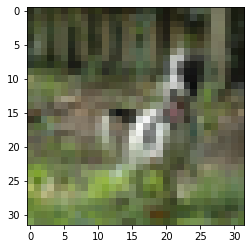

In [5]:
img, label = next(iter(dataset_dogs))

# print(img)
# plt.title(str(label))
plt.imshow(img)

# Get 1000 samples from each dataset class and create validation set

In [6]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
 
# print(val.cardinality())  # returns -2 
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Now I need to split the remaining images of each data set in the remaining datasets into different training groups and
# mini_ds_airplanes = dataset_airplanes.skip(9)
# mini_ds_airplanes = mini_ds_airplanes.take(9)
# B = dataset_airplanes.shard(400, index=0)
# C = dataset_airplanes.shard(1000, index=1)
# list(B.as_numpy_iterator())
# list(C.as_numpy_iterator())
# mini_ds_airplanes
# plt.imshow(feature_dict['image'])
40000/16/10

250.0

# Create 16 small groups of training_sets: plan

The image below is a table of the planned training set divided into 16 groups of 250 images per class, resulting in each of the 16 groups named A through P, having a total of 2500 images each.  There are initially 16 groups, and then they are merged by 2s into 8 groups of 2s, and then 4 groups of 4, until they are merged for the 5th time into one large group of 16 groups, which is the original training set.  This grouping and division allows one to study 5 different image sizes, and the number per class is a relatively easy number to work with for reviewing the final confusion matrices resulting from each run.  Although there are many discrete mathematical combinations possible for combining the groups, this is not the focus of the study, the goal is to have a clear  data division that is repeatable and consistent throughout the test.   

 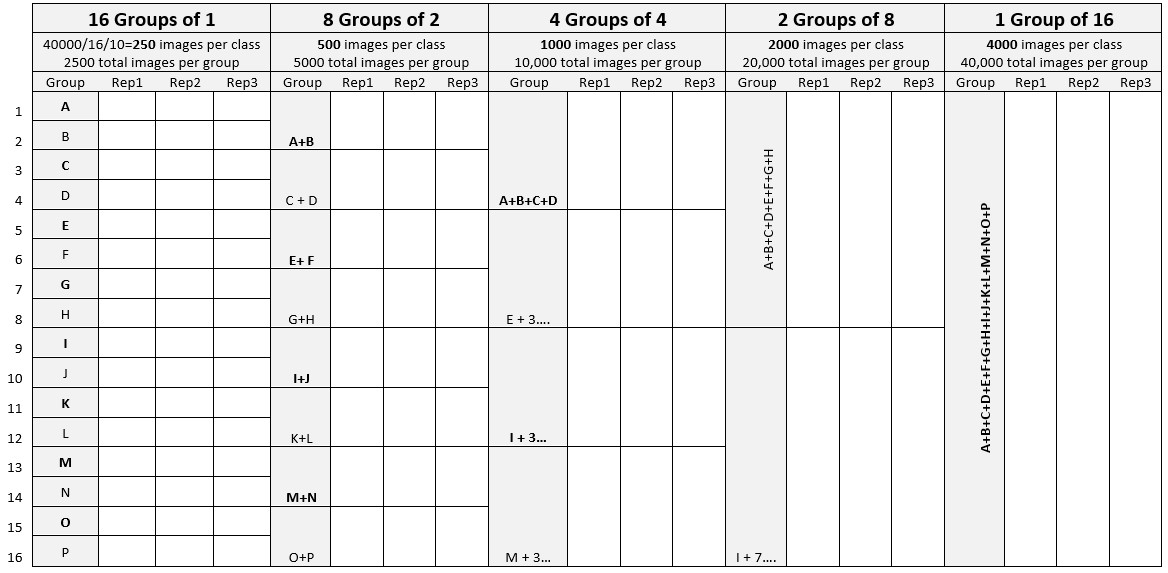

# Create 16 small groups of training_sets: implementation

The plan is to see if I can use shards to make the data division easy.   Can I just "shard" the remaining training set into 16 groups?

#### Airplanes (airplanes_A, ... airplanes_P)

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=16, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=16, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=16, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=16, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=16, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=16, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=16, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=16, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=16, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=16, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=16, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=16, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=16, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=16, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=16, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!







#### Automobiles

In [8]:
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=16, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=16, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=16, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=16, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=16, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=16, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=16, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=16, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=16, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=16, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=16, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=16, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=16, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=16, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=16, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Birds

In [9]:
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=16, index = 0)
birds_B = dataset_birds.shard(num_shards=16, index = 1)
birds_C = dataset_birds.shard(num_shards=16, index = 2)
birds_D = dataset_birds.shard(num_shards=16, index = 3)
birds_E = dataset_birds.shard(num_shards=16, index = 4)
birds_F = dataset_birds.shard(num_shards=16, index = 5)
birds_G = dataset_birds.shard(num_shards=16, index = 6)
birds_H = dataset_birds.shard(num_shards=16, index = 7)
birds_I = dataset_birds.shard(num_shards=16, index = 8)
birds_J = dataset_birds.shard(num_shards=16, index = 9)
birds_K = dataset_birds.shard(num_shards=16, index = 10)
birds_L = dataset_birds.shard(num_shards=16, index = 11)
birds_M = dataset_birds.shard(num_shards=16, index = 12)
birds_N = dataset_birds.shard(num_shards=16, index = 13)
birds_O = dataset_birds.shard(num_shards=16, index = 14)
birds_P = dataset_birds.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Cats

In [10]:
# dataset_cats
 

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=16, index = 0)
cats_B = dataset_cats.shard(num_shards=16, index = 1)
cats_C = dataset_cats.shard(num_shards=16, index = 2)
cats_D = dataset_cats.shard(num_shards=16, index = 3)
cats_E = dataset_cats.shard(num_shards=16, index = 4)
cats_F = dataset_cats.shard(num_shards=16, index = 5)
cats_G = dataset_cats.shard(num_shards=16, index = 6)
cats_H = dataset_cats.shard(num_shards=16, index = 7)
cats_I = dataset_cats.shard(num_shards=16, index = 8)
cats_J = dataset_cats.shard(num_shards=16, index = 9)
cats_K = dataset_cats.shard(num_shards=16, index = 10)
cats_L = dataset_cats.shard(num_shards=16, index = 11)
cats_M = dataset_cats.shard(num_shards=16, index = 12)
cats_N = dataset_cats.shard(num_shards=16, index = 13)
cats_O = dataset_cats.shard(num_shards=16, index = 14)
cats_P = dataset_cats.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!



#### Deer(s)

In [11]:
# dataset_deers

# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=16, index = 0)
deers_B = dataset_deers.shard(num_shards=16, index = 1)
deers_C = dataset_deers.shard(num_shards=16, index = 2)
deers_D = dataset_deers.shard(num_shards=16, index = 3)
deers_E = dataset_deers.shard(num_shards=16, index = 4)
deers_F = dataset_deers.shard(num_shards=16, index = 5)
deers_G = dataset_deers.shard(num_shards=16, index = 6)
deers_H = dataset_deers.shard(num_shards=16, index = 7)
deers_I = dataset_deers.shard(num_shards=16, index = 8)
deers_J = dataset_deers.shard(num_shards=16, index = 9)
deers_K = dataset_deers.shard(num_shards=16, index = 10)
deers_L = dataset_deers.shard(num_shards=16, index = 11)
deers_M = dataset_deers.shard(num_shards=16, index = 12)
deers_N = dataset_deers.shard(num_shards=16, index = 13)
deers_O = dataset_deers.shard(num_shards=16, index = 14)
deers_P = dataset_deers.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Dogs

In [12]:
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=16, index = 0)
dogs_B = dataset_dogs.shard(num_shards=16, index = 1)
dogs_C = dataset_dogs.shard(num_shards=16, index = 2)
dogs_D = dataset_dogs.shard(num_shards=16, index = 3)
dogs_E = dataset_dogs.shard(num_shards=16, index = 4)
dogs_F = dataset_dogs.shard(num_shards=16, index = 5)
dogs_G = dataset_dogs.shard(num_shards=16, index = 6)
dogs_H = dataset_dogs.shard(num_shards=16, index = 7)
dogs_I = dataset_dogs.shard(num_shards=16, index = 8)
dogs_J = dataset_dogs.shard(num_shards=16, index = 9)
dogs_K = dataset_dogs.shard(num_shards=16, index = 10)
dogs_L = dataset_dogs.shard(num_shards=16, index = 11)
dogs_M = dataset_dogs.shard(num_shards=16, index = 12)
dogs_N = dataset_dogs.shard(num_shards=16, index = 13)
dogs_O = dataset_dogs.shard(num_shards=16, index = 14)
dogs_P = dataset_dogs.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [13]:
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=16, index = 0)
frogs_B = dataset_frogs.shard(num_shards=16, index = 1)
frogs_C = dataset_frogs.shard(num_shards=16, index = 2)
frogs_D = dataset_frogs.shard(num_shards=16, index = 3)
frogs_E = dataset_frogs.shard(num_shards=16, index = 4)
frogs_F = dataset_frogs.shard(num_shards=16, index = 5)
frogs_G = dataset_frogs.shard(num_shards=16, index = 6)
frogs_H = dataset_frogs.shard(num_shards=16, index = 7)
frogs_I = dataset_frogs.shard(num_shards=16, index = 8)
frogs_J = dataset_frogs.shard(num_shards=16, index = 9)
frogs_K = dataset_frogs.shard(num_shards=16, index = 10)
frogs_L = dataset_frogs.shard(num_shards=16, index = 11)
frogs_M = dataset_frogs.shard(num_shards=16, index = 12)
frogs_N = dataset_frogs.shard(num_shards=16, index = 13)
frogs_O = dataset_frogs.shard(num_shards=16, index = 14)
frogs_P = dataset_frogs.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Horses

In [14]:
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=16, index = 0)
horses_B = dataset_horses.shard(num_shards=16, index = 1)
horses_C = dataset_horses.shard(num_shards=16, index = 2)
horses_D = dataset_horses.shard(num_shards=16, index = 3)
horses_E = dataset_horses.shard(num_shards=16, index = 4)
horses_F = dataset_horses.shard(num_shards=16, index = 5)
horses_G = dataset_horses.shard(num_shards=16, index = 6)
horses_H = dataset_horses.shard(num_shards=16, index = 7)
horses_I = dataset_horses.shard(num_shards=16, index = 8)
horses_J = dataset_horses.shard(num_shards=16, index = 9)
horses_K = dataset_horses.shard(num_shards=16, index = 10)
horses_L = dataset_horses.shard(num_shards=16, index = 11)
horses_M = dataset_horses.shard(num_shards=16, index = 12)
horses_N = dataset_horses.shard(num_shards=16, index = 13)
horses_O = dataset_horses.shard(num_shards=16, index = 14)
horses_P = dataset_horses.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Ships

In [15]:
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=16, index = 0)
ships_B = dataset_ships.shard(num_shards=16, index = 1)
ships_C = dataset_ships.shard(num_shards=16, index = 2)
ships_D = dataset_ships.shard(num_shards=16, index = 3)
ships_E = dataset_ships.shard(num_shards=16, index = 4)
ships_F = dataset_ships.shard(num_shards=16, index = 5)
ships_G = dataset_ships.shard(num_shards=16, index = 6)
ships_H = dataset_ships.shard(num_shards=16, index = 7)
ships_I = dataset_ships.shard(num_shards=16, index = 8)
ships_J = dataset_ships.shard(num_shards=16, index = 9)
ships_K = dataset_ships.shard(num_shards=16, index = 10)
ships_L = dataset_ships.shard(num_shards=16, index = 11)
ships_M = dataset_ships.shard(num_shards=16, index = 12)
ships_N = dataset_ships.shard(num_shards=16, index = 13)
ships_O = dataset_ships.shard(num_shards=16, index = 14)
ships_P = dataset_ships.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Trucks


In [16]:
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=16, index = 0)
trucks_B = dataset_trucks.shard(num_shards=16, index = 1)
trucks_C = dataset_trucks.shard(num_shards=16, index = 2)
trucks_D = dataset_trucks.shard(num_shards=16, index = 3)
trucks_E = dataset_trucks.shard(num_shards=16, index = 4)
trucks_F = dataset_trucks.shard(num_shards=16, index = 5)
trucks_G = dataset_trucks.shard(num_shards=16, index = 6)
trucks_H = dataset_trucks.shard(num_shards=16, index = 7)
trucks_I = dataset_trucks.shard(num_shards=16, index = 8)
trucks_J = dataset_trucks.shard(num_shards=16, index = 9)
trucks_K = dataset_trucks.shard(num_shards=16, index = 10)
trucks_L = dataset_trucks.shard(num_shards=16, index = 11)
trucks_M = dataset_trucks.shard(num_shards=16, index = 12)
trucks_N = dataset_trucks.shard(num_shards=16, index = 13)
trucks_O = dataset_trucks.shard(num_shards=16, index = 14)
trucks_P = dataset_trucks.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Merge 1/16th of each CIFAR Training Datasets into 16 Small training Groups {A}, {B}, {C} , ... {P}

#### Group A  (train_A)

In [17]:
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i)

# print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 


#### Group B

In [18]:
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [19]:
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [20]:
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [21]:
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [22]:
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [23]:
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [24]:
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [25]:
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [26]:
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

# Test whether I can train a model on just Group A

I will now see if I can use the small group A train set, the val set, and the test set of the CIFAR-10 using a vanilla CNN

Adding Batches, Buffers, Shuffles and Caches

The following is necessary to run the datasets through the models.  Do not run the following more than once because it'll try to make an additional dimension in your datasets

In [27]:
if initial_run == 0: 
    
  # remember that train_A and val are NOT shuffled at all

  # https://www.tensorflow.org/tutorials/load_data/images#train_a_model says
  # Configure the dataset for performance
  # Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:
  # Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
  # Dataset.prefetch overlaps data preprocessing and model execution while training.


  AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(2500, reshuffle_each_iteration=True, seed=seed)
  train_A = train_A.batch(100)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure

  # I want to view whats in my train_A but the followin code results in an error: TypeError: tuple indices must be integers or slices, not str
  # for sample in train_A.take(10):
  #     image,label = sample['image'].numpy(), sample["label"].numpy()
  #     plt.imshow(image[:,:,:].astype(np.uint8))
  #     plt.show()
  #     print("Label: %d" % label)

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  # The problem with https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model i
  # is it doesn't explain how to use a model.evaluate function with tfds.load()
  # x_test = x_test.num_parallel_calls(tf.data.AUTOTUNE)  # AttributeError: 'PrefetchDataset' object has no attribute 'num_parallel_calls'
  x_test = x_test.batch(10000)
  x_test = x_test.cache()
  x_test = x_test.prefetch(tf.data.AUTOTUNE)
else:
  pass

initial_run = initial_run+1

#### Time required to create datasets: 108 seconds

In [28]:
toc = time.time()  
print(toc - tic, " seconds")
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


71.44818234443665  seconds
Made datasets in 71.4482 seconds


## Train the model :


Epoch 1/100
25/25 [==============================] - 34s 125ms/step - loss: 3.5800 - accuracy: 0.1792 - val_loss: 2.4433 - val_accuracy: 0.1594
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 2.7920 - accuracy: 0.2800 - val_loss: 2.3341 - val_accuracy: 0.1552
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 2.4851 - accuracy: 0.3204 - val_loss: 2.1217 - val_accuracy: 0.2270
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 2.0936 - accuracy: 0.3792 - val_loss: 2.0954 - val_accuracy: 0.2359
Epoch 5/100
25/25 [==============================] - 0s 18ms/step - loss: 1.9326 - accuracy: 0.4156 - val_loss: 2.0659 - val_accuracy: 0.2459
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 1.7780 - accuracy: 0.4412 - val_loss: 2.0679 - val_accuracy: 0.2709
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 1.6260 - accuracy: 0.4724 - val_loss: 1.8940 - val_accuracy: 0.3194
Epoc

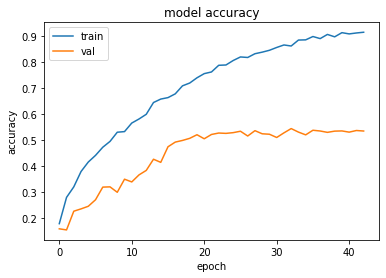

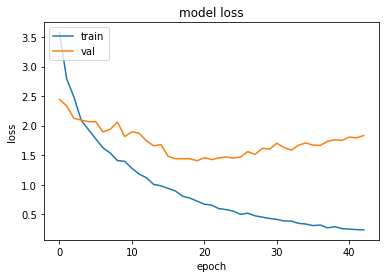

In [29]:
# Make a Vanilla CNN
num_classes = 10
input_shape = (32, 32, 3)

# For Reference these are the defaults
# kernel_initializer="glorot_uniform",
# bias_initializer="zeros",
# padding="valid",  #valid = no padding
# kernel_regularizer=None,
# bias_regularizer=None,
# activity_regularizer=None,

initializer = tf.keras.initializers.HeUniform(seed)

model = tf.keras.Sequential(
[
    #keras.Input(),
    tf.keras.Input(shape=input_shape),

    layers.experimental.preprocessing.Rescaling(1./255),
    #data_augmentation,   
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
    layers.BatchNormalization(name="BN1"),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
    layers.BatchNormalization(name="BN2"),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
    layers.BatchNormalization(name="BN3"),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu", kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")

])




model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])  #changed, added to val_accuracy

model.save_weights('saved_model/blank_model')
model.load_weights('saved_model/blank_model')

history = model.fit(
  train_A,
  validation_data=(val),
  epochs=100,
  callbacks = keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=10, restore_best_weights=True, 
                                            verbose=0),
)

 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Time Required to Train and Validate (Baseline) 64 seconds

In [30]:
tock = time.time()  
print(tock - toc, " seconds")
print(f"Trained model in {tock - toc:0.4f} seconds")

66.16118001937866  seconds
Trained model in 66.1612 seconds


In [31]:
model.save('saved_model/my_model')

# new_model = tf.keras.models.load_model('saved_model/my_model')

# # Check its architecture
# new_model.summary()

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Evaluate Model on Test Set

In [32]:
# model.predict(x_test) fails with error:
# WARNING:tensorflow:Model was constructed with shape (None, 32, 32, 3) for...\
#   input KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), 
#   name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (32, 32, 3).
#   so I think I need to give it "batch" sizes 


# # # I don't know if below works - I could check by running with and without it
# AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
# x_test = x_test.cache().prefetch(buffer_size=AUTOTUNE)
# # x_test = x_test.shuffle(10000, reshuffle_each_iteration=False)
# x_test = x_test.batch(1000)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure

 
print("Y_test : ", y_test)
print("X_test : ", x_test)
print("TrainA : ", train_A)

# test_images = list(map(lambda x: x[0], x_test))
# y_test = list(map(lambda x: x[1], x_test))


model.evaluate(x_test, verbose=2)  # I have this written in preious cell
## WORKED!!!!!!!!!!!!!!!!!!!!!!!
# 79/79 - 1s - loss: 1.4953 - accuracy: 0.5314
# [1.4952507019042969, 0.5314000248908997]


Y_test :  tf.Tensor([7 0 6 ... 8 6 0], shape=(10000,), dtype=int64)
X_test :  <PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>
TrainA :  <BatchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>
1/1 - 1s - loss: 1.5707 - accuracy: 0.5429


[1.5706686973571777, 0.542900025844574]

When the training dataset has no shuffle per iterations the model results in the following test-accuracy: 0.5329, 0.5376, 0.5391, 0.5346, 0.5339999, 0.5361

which seem to suggest the mean baseline is:
**0.5353** and theres a run to run std dev of **0.0023** (or 0.2%) and a possible max difference between runs of **0.00621**.  The variance is the square of the std.dev so it is a very small number.  

Loss is 2.1650421619415283

When the training dataset has a shuffle-per-iteration with a pseudo-random seed the following accuracies resulst: 0.5346999,    0.5309, 0.5479, 0.5479 again


### Confusion Matrix on Test-Set Data 

[[567  81  89  21   8  15  15  10 159  35]
 [ 33 722  13  13   7   9  21  10  56 116]
 [ 89  16 448 104  56 106  75  53  34  19]
 [ 29  19  97 397  42 234  97  40  29  16]
 [ 54  11 158  90 326 113  90 114  26  18]
 [ 18  10  95 205  32 493  42  68   9  28]
 [ 15  16  85  99  30  45 667  15  13  15]
 [ 37  22  34  77  35 124  17 592  10  52]
 [150  78  18  24   8   7   8   3 629  75]
 [ 43 186  18  23   6  14  18  17  87 588]]


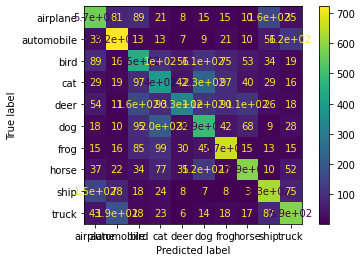

In [33]:


 
# print(y_test)  # 1 column? of actual labels.
y_pred = model.predict(x_test)
# print(y_pred)  # 10 columns? of softmax
# I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
y_pred_1hot = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )  #doesnt run because
# alueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets
# WORKS NOW


disp = ConfusionMatrixDisplay(cm, display_labels=['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']).plot()

print(cm)

## Confusion Matrix of Training-Cats Dataset (for sanity check)

I wanted to verify the confusion matrix was working, so I sent just `cats_A`, through the predictive model.  I figured out that scikits `confusion_matrix` only saw and used the numerical values from the prediction and that's why it looked like it was skipping an index.  Thanks [SO](https://stackoverflow.com/questions/35162652/construct-confusion-matrix-with-missing-data)  

In [34]:
if initial_run == 1:
   cats_A = cats_A.batch(250)


[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 6 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 246   1   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


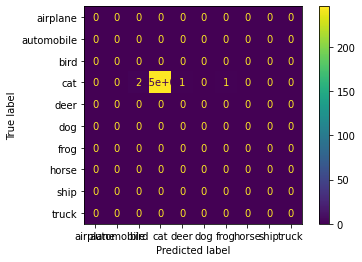

In [35]:
# # print(y_test)  # 1 column? of actual labels.



preds_cats = model.predict(cats_A)
# # print(y_pred)  # 10 columns? of softmax
# # I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
preds_cats = np.argmax(preds_cats, axis=1)


print(preds_cats)  #- lots of threes predicted which is good
# # [3 3 3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 2 3 3 3 4 3 3 3 3 6 3 3 3 3 3 3 3 3
# #  3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3
# #  6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3 3 3
# #  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 6 4 3 3 3 3 3 3 3 3 3 3 3 3
# #  3 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 3 3 3 3 3 3 3 3 3 6 4 3 3 3 2 3 3 3 3
# #  3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

np.unique(preds_cats)
# #I need y_true or "cat_true", which is cat_A labels, to be defined here as an eagertensor, like it was for y_test, so I guess I should define it hte same way I defined y_test

y_cats = get_labels_from_tfdataset(cats_A)

# print(y_cats)  # Printsa tf.Tensor of 3s (250 of them) which is correct
# # tf.Tensor(
# [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
#  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(250,), dtype=int64)

# so Im guessing that means my confusion matrix index starts at 1 and misses class 0
cm2 = confusion_matrix(y_true = y_cats, y_pred = preds_cats , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  #doesnt run because
# alueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets
# WORKS NOW
print(cm2)

disp2 = ConfusionMatrixDisplay(cm2, display_labels= ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']).plot()

Now I see cats are most commonly predicted to be dogs.  I want to highlight and show the pictures of the Cats that were predicted to be Dogs, and perhaps, show the pictures of Cats that are predicted to be Cats

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


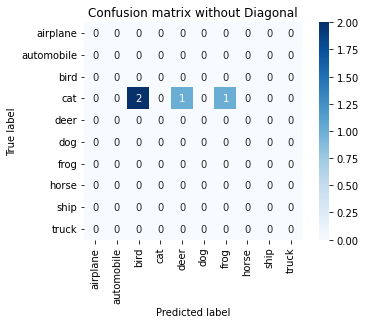

In [36]:
CLASSES = info.features['label'].names

def show_confusion_matrix(test_labels, predictions, CLASSES):
  """Compute confusion matrix and normalize."""
  confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  
  
  confusing_part_matrix= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)
  print(confusing_part_matrix)
  # print(confusion)
  # print(confusion.astype("float"))
  # print(confusion.sum(axis=1))
  # # confusion_normalized = np.divide(confusion.astype("float"), confusion.sum(axis=1))
  # confusion_normalized = np.where(confusing_part_matrix> 0, np.divide(confusing_part_matrix.astype("float"), confusing_part_matrix.sum(axis=1)), 0)
  axis_labels = CLASSES
  # ax = sns.heatmap(
  #     confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
  #     cmap='Blues', annot=True, fmt='.2f', square=True)
  ax = sns.heatmap(
      confusing_part_matrix, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, square=True)

  plt.title("Confusion matrix without Diagonal")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

 
show_confusion_matrix(y_cats, preds_cats, CLASSES = CLASSES)  # this is the training set, so a lot less will show up on the confusion matrix, I got four on this run

# confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
# show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

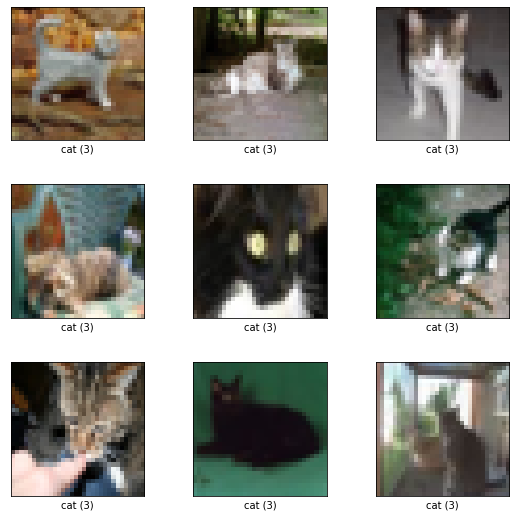

[ 23  28 113 186]


In [37]:
fig = tfds.show_examples(tf.data.Dataset.unbatch(cats_A), info)

# I want to identify images that wer not predicted as cats
errors = ( preds_cats - 3 !=0 )  # IF predicted class is 3, then a correct prediction yields 3-3 = 0.  

#print(errors) # this prints the answer to 250 questions, I just want the index of the wrong ones with respect to the 250

index, = np.where(errors == True)
print(index)

 

In [38]:
 
# # # Continued attempt to view the wrong classified images
# # # https://stackoverflow.com/questions/66410340/filter-tensorflow-dataset-by-id

# # Rebuilding Toy Exampe from stackover flow
# m_X_ds = tf.data.Dataset.from_tensor_slices(list(range(1, 21))).shuffle(10, reshuffle_each_iteration=False)
# arr = np.array([3, 4, 5])

# # Option A
# m_X_ds = list(m_X_ds)  # Load into memory.
# m_X_ds = tf.gather(m_X_ds, arr) # Gather as usual.
# print(m_X_ds)  
# # Example result: <tf.Tensor: shape=(3,), dtype=int32, numpy=array([8, 6, 2], dtype=int32)>


# # -----------------------
# # So I want to get cats_A_ids and arr = errors

# new_index  = np.array([17,  36,  39, 113, 153, 176])

# cats_A_wrong = list(tf.data.Dataset.unbatch(cats_A))
# cats_A_wrong = tf.gather(cats_A_wrong, new_index)
# print(cats_A_wrong)

In [39]:
# # ## Attempt 3001
# # #https://stackoverflow.com/questions/41135302/how-to-display-a-misclassified-image
# # # 
# # # computation graph
# # predictions = argmax(softmax(final_layer))
# # matches = predictions == argmax(labels) # if one-hot encoded

# # # later
# # batch_matches = sess.run(matches, feed_dict={...})

# # for image, does_match in zip(batch_images, batch_matches):
# #   if not does_match:
# #     cv2.imwrite('mismatched.png', image)

# # Attempt 3004
# img, label = next(iter(cats_A_wrong))  #just unbatched cats_A for now, not really wrong

# # print(img)
# # plt.title(str(label))
# plt.imshow(img)

In [40]:
# # fnames = cats_A.image ## fnames is all the filenames/samples used in testing
# #errors = np.where(y_pred != test_generator.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
# # for i in errors:
# #     print(fnames[i])

# # # for i in cats_A.enumerate
# # #   where(i == arr)
# cats_A.info.splits.keys()

# builder.info.splits['train'].num_examples  # 10_000
# builder.info.splits['train[:75%]'].num_examples  # 7_500 (also works with slices)
# builder.info.splits.keys()  # ['train', 'test']

# Transition to Augmentations


In [41]:
start_augmentations = time.time()

# Using Albumentations with Tensorflow

**Author**: [Ayushman Buragohain](https://github.com/benihime91)

## Prepare the Google Colab environment

#### Download images

Download images that are used in the notebook and save to the `images` folder in the Colab environment.

In [42]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [43]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 8.2 MB/s 
     |████████████████████████████████| 47.6 MB 76 kB/s 
albumentations==1.1.0 is successfully installed


## Run the example

#### [Recommended] Update the version of tensorflow_datasets if you want to use it

- We'll we using an example from `tensorflow_datasets`.

In [44]:
# ! pip install --upgrade tensorflow_datasets

## Run the example

In [45]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [46]:
tfds.__version__

'4.0.1'

In [47]:
# # # load in the tf_flowers dataset
# # data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
# # data

# data, info = tfds.load('cifar10', split="train", as_supervised=True, with_info=True)

## An Example Pipeline Using `tf.image`

## View images from the dataset

In [48]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amounts of augmentations to our `input data`.
One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

# An Example Pipeline using `albumentations`

To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

italicized text## Create Pipeline to Process data

In [49]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [50]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [51]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [52]:
# create dataset
IMG_SIZE = 32
# ds_alb = data.map(partial(process_data, img_size=IMG_SIZE),
#                   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# # ds_alb



## Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [53]:
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [54]:
# ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
# ds_alb

## View images from the train_A dataset

In [157]:
unbatch_cats_A =(tf.data.Dataset.unbatch(cats_A))

cats_A_noalb = unbatch_cats_A.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(20).prefetch(AUTOTUNE) 

# create dataset
cats_A_alb = unbatch_cats_A.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
 

cats_A_alb = cats_A_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(20).prefetch(AUTOTUNE) 
 

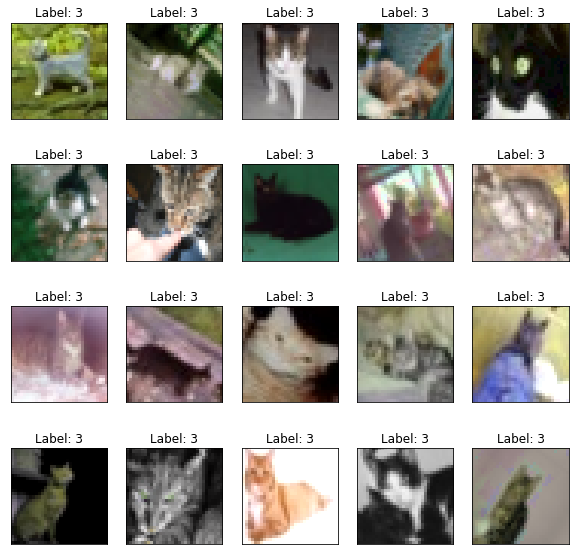

In [161]:
view_image(cats_A_alb)

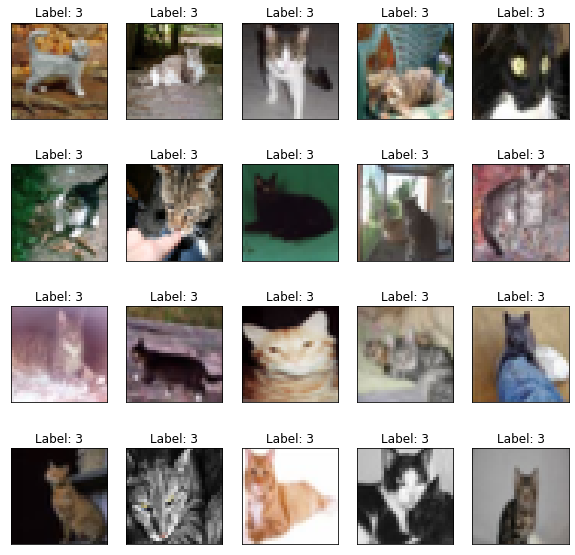

In [160]:
view_image(cats_A_noalb)



## `Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

## Train
